<div style="color:white;display:fill;border-radius:8px;
            background-color:#a7d5ed;font-size:170%;
            font-family:Nexa;letter-spacing:4.5px;">    
    <h1 style="padding:15px;color:black;text-align: center"> Tunning Hyperparameters LGBM</h1> 
</div>

![](https://storage.googleapis.com/kaggle-competitions/kaggle/26480/logos/header.png?t=2021-04-09-00-57-05)

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 1. IMPORTAÇÕES </h1>    
</div>

## 1.1. Instalações

In [1]:
# https://pub.towardsai.net/use-google-colab-like-a-pro-39a97184358d
COLAB = 'google.colab' in str(get_ipython()) 

if COLAB:        
    !pip install --q scikit-plot
    !pip install --q category_encoders
    !pip install --q shap
    !pip install --q inflection  
    !pip install --q optuna  
    !pip install --q Boruta
    !pip install --q GPUtil
    #!pip install --q pycaret

    from google.colab import drive
    drive.mount('/content/drive')

## 0.1. Bibliotecas

In [2]:
import optuna
import re
import warnings
import random
import os
import gc
import torch
import math
import sklearn.exceptions
import datetime
import shap
import glob

In [3]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt 
import seaborn           as sns
import joblib            as jb
import xgboost           as xgb
import lightgbm          as lgb
import scikitplot        as skplt

In [4]:
import torch
import torch.nn             as nn

In [5]:
from sklearn                     import metrics
from sklearn.feature_selection   import SelectKBest, SelectPercentile, f_classif
from sklearn.model_selection     import train_test_split,  KFold, StratifiedKFold
from sklearn.preprocessing       import StandardScaler, MinMaxScaler, RobustScaler, Normalizer 
from sklearn.preprocessing       import MaxAbsScaler, QuantileTransformer, LabelEncoder
from sklearn.impute              import SimpleImputer
from sklearn                     import metrics
from datetime                    import datetime

In [6]:
from optuna.samplers               import TPESampler
from optuna.visualization          import plot_edf
from optuna.visualization          import plot_optimization_history
from optuna.visualization          import plot_parallel_coordinate
from optuna.visualization          import plot_param_importances
from optuna.visualization          import plot_slice
from optuna.visualization          import plot_intermediate_values
from optuna.visualization          import plot_contour
from optuna.pruners                import MedianPruner
from optuna.pruners                import BasePruner
from optuna.trial._state           import TrialState

In [7]:
from GPUtil                        import showUtilization as gpu_usage
from numba                         import cuda
from sklearn.ensemble              import IsolationForest
from psutil                        import virtual_memory
from datetime                      import datetime
from psutil                        import virtual_memory
from sklearn.utils.class_weight    import compute_sample_weight
from boruta                        import BorutaPy
from multiprocessing               import cpu_count
from sklearn.calibration           import CalibrationDisplay

## 0.2. Funções

In [8]:
def jupyter_setting():
    
    %matplotlib inline
      
    #os.environ["WANDB_SILENT"] = "true" 
    #plt.style.use('bmh') 
    #plt.rcParams['figure.figsize'] = [20,15]
    #plt.rcParams['font.size']      = 13
     
    pd.options.display.max_columns = None
    #pd.set_option('display.expand_frame_repr', False)

    warnings.filterwarnings(action='ignore')
    warnings.simplefilter('ignore')
    warnings.filterwarnings('ignore')
    warnings.filterwarnings('ignore', category=DeprecationWarning)
    warnings.filterwarnings('ignore', category=FutureWarning)
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    warnings.filterwarnings('ignore', category=UserWarning)
    warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
    warnings.filterwarnings("ignore", category= sklearn.exceptions.UndefinedMetricWarning)

    pd.set_option('display.max_rows', 200)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.max_colwidth', None)

    icecream = ["#00008b", "#960018","#008b00", "#00468b", "#8b4500", "#582c00"]
    #sns.palplot(sns.color_palette(icecream))
    
    colors = ["lightcoral", "sandybrown", "darkorange", "mediumseagreen",
          "lightseagreen", "cornflowerblue", "mediumpurple", "palevioletred",
          "lightskyblue", "sandybrown", "yellowgreen", "indianred",
          "lightsteelblue", "mediumorchid", "deepskyblue"]
    
    # Colors
    dark_red   = "#b20710"
    black      = "#221f1f"
    green      = "#009473"
    myred      = '#CD5C5C'
    myblue     = '#6495ED'
    mygreen    = '#90EE90'    
    color_cols = [myred, myblue,mygreen]
    
    return icecream, colors, color_cols

icecream, colors, color_cols = jupyter_setting()

In [9]:
def jupyter_setting():
    
    %matplotlib inline
      
    #os.environ["WANDB_SILENT"] = "true" 
    #plt.style.use('bmh') 
    #plt.rcParams['figure.figsize'] = [20,15]
    #plt.rcParams['font.size']      = 13
     
    pd.options.display.max_columns = None
    #pd.set_option('display.expand_frame_repr', False)

    warnings.filterwarnings(action='ignore')
    warnings.simplefilter('ignore')
    warnings.filterwarnings('ignore')
    warnings.filterwarnings('ignore', category=DeprecationWarning)
    warnings.filterwarnings('ignore', category=FutureWarning)
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    warnings.filterwarnings('ignore', category=UserWarning)
    warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
    warnings.filterwarnings("ignore", category= sklearn.exceptions.UndefinedMetricWarning)

    pd.set_option('display.max_rows', 200)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.max_colwidth', None)

    icecream = ["#00008b", "#960018","#008b00", "#00468b", "#8b4500", "#582c00"]
    #sns.palplot(sns.color_palette(icecream))
    
    colors = ["lightcoral", "sandybrown", "darkorange", "mediumseagreen",
          "lightseagreen", "cornflowerblue", "mediumpurple", "palevioletred",
          "lightskyblue", "sandybrown", "yellowgreen", "indianred",
          "lightsteelblue", "mediumorchid", "deepskyblue"]
    
    # Colors
    dark_red   = "#b20710"
    black      = "#221f1f"
    green      = "#009473"
    myred      = '#CD5C5C'
    myblue     = '#6495ED'
    mygreen    = '#90EE90'    
    color_cols = [myred, myblue,mygreen]
    
    return icecream, colors, color_cols

icecream, colors, color_cols = jupyter_setting()

In [10]:
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [11]:
def missing_zero_values_table(df):
        mis_val         = df.isnull().sum()
        mis_val_percent = round(df.isnull().mean().mul(100), 2)
        mz_table        = pd.concat([mis_val, mis_val_percent], axis=1)
        mz_table        = mz_table.rename(columns = {df.index.name:'col_name', 
                                                     0 : 'Valores ausentes', 
                                                     1 : '% de valores totais'})
        
        mz_table['Tipo de dados'] = df.dtypes
        mz_table                  = mz_table[mz_table.iloc[:,1] != 0 ]. \
                                     sort_values('% de valores totais', ascending=False)
        
        msg = "Seu dataframe selecionado tem {} colunas e {} " + \
              "linhas. \nExistem {} colunas com valores ausentes."
            
        print (msg.format(df.shape[1], df.shape[0], mz_table.shape[0]))
        
        return mz_table.reset_index()

In [12]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.rcParams['font.size'] = 12
    plt.title('Precision Recall vs threshold')
    plt.xlabel('Threshold')
    plt.legend(loc="lower left")
    
    plt.grid(True)

In [13]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls[:-1], precisions[:-1], "b-", label="Precision")
    
    plt.rcParams['font.size'] = 12
    plt.title('Precision vs recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # plt.legend(loc="lower left")
    
    plt.grid(True)

In [14]:
def plot_roc_curve(fpr, tpr, label=None):
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, "r-", label=label)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 12
    plt.title('XGBR ROC curve for TPS 09')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.legend(loc="lower right")
    plt.grid(True)

In [15]:
def graf_feature_corr(df, annot_=False, threshold=.8, print_var=False, print_graf=True):
    
    df = df.corr(method ='pearson').round(5)

    if print_graf: 
        # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
        mask = np.zeros_like(df)
        mask[np.triu_indices_from(mask)] = True

        # Making a plot
        ax = sns.heatmap(df, annot=annot_, mask=mask, cmap="RdBu", annot_kws={"weight": "bold", "fontsize":13})

        ax.set_title("Mapa de calor de correlação das variável", fontsize=17)

        plt.setp(ax.get_xticklabels(), 
                 rotation      = 90, 
                 ha            = "right",
                 rotation_mode = "anchor", 
                 weight        = "normal")

        plt.setp(ax.get_yticklabels(), 
                 weight        = "normal",
                 rotation_mode = "anchor", 
                 rotation      = 0, 
                 ha            = "right");

    if print_var: 
        
        df_corr = df[abs(df)>threshold][df!=1.0].unstack().dropna().reset_index()
        if len(df_corr)>0:            
            print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold))
            df_corr.columns =  ['var_1', 'var_2', 'corr']
            display(df_corr)
        else: 
            print('Não tem variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold))


In [16]:
def correlation(dataset, threshold):

    col_corr    = set()  # Conjunto de todos os nomes de colunas correlacionadas
    corr_matrix = dataset.corr()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >= threshold: # estamos interessados no valor coeficiente absoluto
                colname = corr_matrix.columns[i]        # obtendo o nome da coluna
                col_corr.add(colname)
    
    return col_corr

In [17]:
def free_gpu_cache():
    
    # https://www.kaggle.com/getting-started/140636
    #print("Initial GPU Usage")
    #gpu_usage()                             

    #cuda.select_device(0)
    #cuda.close()
    #cuda.select_device(0)   
    
    gc.collect()
    torch.cuda.empty_cache()

In [18]:
def diff(t_a, t_b):
    from dateutil.relativedelta import relativedelta
    t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
    return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

In [19]:
def describe(df):
    var = df.columns

    # Medidas de tendência central, média e mediana 
    ct1 = pd.DataFrame(df[var].apply(np.mean)).T
    ct2 = pd.DataFrame(df[var].apply(np.median)).T

    # Dispensão - str, min , max range skew, kurtosis
    d1 = pd.DataFrame(df[var].apply(np.std)).T
    d2 = pd.DataFrame(df[var].apply(min)).T
    d3 = pd.DataFrame(df[var].apply(max)).T
    d4 = pd.DataFrame(df[var].apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(df[var].apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(df[var].apply(lambda x: x.kurtosis())).T
    d7 = pd.DataFrame(df[var].apply(lambda x: (3 *( np.mean(x) - np.median(x)) / np.std(x) ))).T

    # concatenete 
    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
    m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis','coef_as']
    
    return m

In [20]:
def plot_roc_curve(fpr, tpr, label=None):
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, "r-", label=label)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve for TPS 09')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.legend(loc="lower right")
    plt.grid(True)

In [21]:
def confusion_plot(matrix, labels = None, title = None):
        
    labels = labels if labels else ['Negative (0)', 'Positive (1)']    
    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    
    sns.heatmap(data        = matrix, 
                cmap        = 'Blues', 
                annot       = True, 
                fmt         = 'd',
                xticklabels = labels, 
                yticklabels = labels, 
                ax          = ax);
    
    ax.set_xlabel('\n PREVISTO', fontsize=15)
    ax.set_ylabel('REAL \n', fontsize=15)
    ax.set_title(title)
    
    plt.close();
    
    return fig;

In [22]:
def graf_outlier(df, feature):
    col = [(0,4), (5,9)]

    df_plot = ((df[feature] - df[feature].min())/
               (df[feature].max() - df[feature].min()))

    fig, ax = plt.subplots(len(col), 1, figsize=(15,7))

    for i, (x) in enumerate(col): 
        sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]); 

In [23]:
def graf_eval():

    results     = model.evals_result()
    ntree_limit = model.best_ntree_limit

    plt.figure(figsize=(20,7))

    for i, error in  enumerate(['mlogloss', 'merror']):#
        
        plt.subplot(1,2,i+1)
        plt.plot(results["validation_0"][error], label="Treinamento")
        plt.plot(results["validation_1"][error], label="Validação")

        plt.axvline(ntree_limit, 
                    color="gray", 
                    label="N. de árvore ideal {}".format(ntree_limit))
                    
        
        title_name ='\n' + error.upper() + ' PLOT \n'
        plt.title(title_name)
        plt.xlabel("Número de árvores")
        plt.ylabel(error)
        plt.legend();

## 0.3. GPU

### 0.3.1. Informações

In [24]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon May 30 20:18:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.69       Driver Version: 511.69       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   55C    P8    N/A /  N/A |   1160MiB /  4096MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 0.3.2. Memória

In [25]:
ram_gb = virtual_memory().total / 1e9

print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 17.0 gigabytes of available RAM

Not using a high-RAM runtime


## 0.4. Dados

### 4.1. Estrutura de diretório

In [26]:
path        = '/content/drive/MyDrive/kaggle/Tabular Playground Series/2022/05 - Maio/' if COLAB else ''    
path_data   = 'Data/'  
target      = 'target'
path_automl = 'automl/'

In [27]:
paths = ['img', 'Data', 'Data/pkl', 'Data/submission', 'Data/tunning', 
         'model', 'model/preds', 'model/optuna','model/preds/test', 'Data/shap',
         'model/preds/test/n1', 'model/preds/test/n2', 'model/preds/test/n3', 
         'model/preds/train', 'model/preds/train/n1', 'model/preds/train/n2', 
         'model/preds/train/n3', 'model/preds/param', 'model/mdl', 'model/preds/folds' ]

for p in paths:
    try:
        os.mkdir(path + p)       
    except:
        pass   

### 4.2. Carregar Datasets

In [28]:
df3_train     = jb.load(path + path_data + 'pkl/df3_train_fe_4.pkl.z')
df3_test      = jb.load(path + path_data + 'pkl/df3_test_fe_4.pkl.z')
df_submission = pd.read_csv(path + path_data + 'sample_submission.csv')

df3_train.shape, df3_test.shape, df_submission.shape

((900000, 62), (700000, 61), (700000, 2))

In [29]:
df3_train.head()

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_28,f_29,f_30,target,fe_02_21,fe_05_22,fe_i_00_01_26,fe_27_a,fe_27_b,fe_27_c,fe_27_d,fe_27_e,fe_27_f,fe_27_g,fe_27_h,fe_27_i,fe_27_j,fe_27_k,fe_27_l,fe_27_m,fe_27_n,fe_27_o,fe_27_p,fe_27_q,fe_27_r,fe_27_s,fe_27_t,fe_27_count_unique,fe_27_count_zero,fe_27_mean,fe_27_sum,fe_27_std,fe_outlier,fe_pca_0,fe_pca_1
0,-1.373047,0.238892,-0.243408,0.567383,-0.647949,0.839355,0.113159,1,5,1,3,3,3,1,6,1,0,7,4,0.298340,-0.919922,3.058594,-2.541016,0.767090,-2.730469,-0.208130,1.363281,67.625,0,0,0,0,0,0,4,4,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,17,3.333984,10,0.942871,0,-3.637714,-5.339258
1,1.697266,-1.709961,-2.230469,-0.545898,1.113281,-1.551758,0.447754,1,3,4,0,2,3,0,1,0,4,6,0,-3.148438,-1.075195,2.179688,2.277344,-0.633789,-1.216797,-3.781250,-0.058319,377.000,0,0,1,0,0,0,3,1,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,15,2.000000,10,1.264648,0,-4.160857,-5.274908
2,1.681641,0.616699,-1.027344,0.810547,-0.608887,0.113953,-0.708496,1,0,2,6,6,4,3,1,2,2,1,4,2.820312,-3.484375,-0.784180,-1.385742,-0.520508,-0.009125,2.789062,-3.703125,-195.625,0,2,1,0,0,0,5,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,6,14,1.666992,10,1.490234,0,-3.205235,5.057066
3,-0.118164,-0.587891,-0.804688,2.085938,0.371094,-0.128784,-0.282471,3,2,1,0,1,6,4,2,3,3,0,3,1.081055,-2.099609,-2.343750,0.572754,-1.653320,1.685547,-2.533203,-0.608398,210.875,0,0,1,0,0,0,2,5,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,16,2.500000,10,1.500000,0,-3.635226,-5.175442
4,1.148438,-0.176514,-0.665039,-1.101562,0.467773,0.500000,0.407471,3,3,0,4,3,0,6,0,3,3,1,0,-0.126221,0.604980,1.133789,-3.912109,-1.430664,2.126953,-3.306641,4.371094,-217.250,0,1,1,0,0,1,0,4,2,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6,14,1.666992,10,1.105469,0,-2.891048,-0.461735


In [30]:
df3_train = reduce_memory_usage(df3_train)
df3_test  = reduce_memory_usage(df3_test)

Mem. usage decreased to 70.38 Mb (25.5% reduction)
Mem. usage decreased to 54.07 Mb (25.7% reduction)


<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 1.  Modelagem </h1>    
</div>

## 1.1. Funções

In [31]:
def delete_files(namefile):
                
        path = ['model/train', 'model/test', 'model/valid', 'model/params', 'model/score',
                'model/test_f', 'model/cv_model', 'model/preds', 'model/optuna', 
                'model/preds/train', 'model/preds/test', 'model/preds/test/n1', 
                'model/preds/test/n2', 'model/preds/test/n3', 'model/preds/train/n1', 
                'model/preds/train/n2', 'model/preds/train/n3','model/preds/param', 
                'Data/submission/tunning', 'Data/submission', 'model/mdl'                
               ]

        for path_ in path:
            for raiz, diretorios, arquivos in os.walk(path_):
                for arquivo in arquivos:
                    if arquivo.startswith(namefile):
                        os.remove(os.path.join(raiz, arquivo))

In [32]:
def save_data_model(model_, model_name_, path_, df_, y_pred_test_prob_, y_pred_test_subm_, score_, 
                    seed_, level_='1', target_='target', cutoff_value_=.6, save_submission_=True, 
                    save_predictions_=True):    
    
    level = 'n' + level_ + '/'

    if score_>cutoff_value_:    
        
        path_name_param = path_ + 'model/preds/param/' + model_name_.format(score_, seed_) + '.pkl.z'
        path_name_train = path_ + 'model/preds/train/' + level + model_name_.format(score_, seed_) + '.pkl.z'
        path_name_test  = path_ + 'model/preds/test/'  + level + model_name_.format(score_, seed_) + '.pkl.z'   
        path_name_model = path_ + 'model/mdl/'         + model_name_.format(score_, seed_) + '.pkl.z'   
        
        if save_predictions_:
            delete_files(model_name_)

            jb.dump(df_, path_name_train)
            jb.dump(y_pred_test_prob_, path_name_test)
            jb.dump(model_, path_name_model)

        if save_submission_:
            model_name_ = model_name_.format(score_, seed_)
            df_submission[target] = y_pred_test_subm_
            df_submission.to_csv(path_ + 'Data/submission/' + model_name_+ '.csv', index=False)

In [33]:
def df_return_preds_stacking(shape_, model_name_=None, path_='', target_='target', level=1): 

    if level==1: 
        level_ = 'n1'
    else: 
        if level==2:
            level_ = 'n2'
        else: 
            level_ = 'n3'

    paths = ['model/preds/test/'+ level_, 'model/preds/train/' + level_ ]    

    if model_name_==None: 
        model_name_=''

    for i, p in enumerate(paths): 

        p = path_ + p 

        name_file_pkl     = glob.glob(p + '/'+ model_name_ + '*.pkl.z')
        dic_preds_mdl_pkl = dict()    

        for p_name in name_file_pkl:    
            y_model_pkl_name_col  = p_name.replace(p + '\\', '').replace('.pkl.z','') 
            #y_model_pkl           = jb.load(p_name)
            df_pkl =jb.load(p_name)

            
            if i==0: 
                x_proba = df_pkl
                dic_preds_mdl_pkl[y_model_pkl_name_col] = x_proba
            else: 
                if shape_==len(df_pkl): 
                    x_proba = df_pkl['y_proba']        
                    dic_preds_mdl_pkl[y_model_pkl_name_col] = x_proba

        if i==0:
            df_ts = pd.DataFrame(dic_preds_mdl_pkl)
        else: 
            df_tr = pd.DataFrame(dic_preds_mdl_pkl) 
            df_tr[target_] = df_pkl['y_proba']
         
    cols_stanking = df_tr.columns.to_list()
    cols_stanking.remove(target_)
    df_ts = df_ts[cols_stanking]

    return df_tr, df_ts 

In [93]:
def cross_val_model(model_, model_name_, X_, y_, X_test_, target_, scalers_, lb_, fold_=5, path_='',  
                    seed_=12359, feature_scaler_=None, print_report_=False, save_submission_=False, 
                    save_predict_=False, level_='1', cutoff_value_save_=.6, print_result_best_=True,
                    train_with_created_folds_=False, is_tunning_=False, save_predictions_=False, 
                    model_type_=1):
    
    n_estimators = model_.get_params()['n_estimators']
             
    valid_preds     = {}
    taco            = 76 
    acc_best        = 0  
    df_proba        = pd.DataFrame()
    feature_imp     = pd.DataFrame()
    test_preds      = []
    preds           = []
    model           = []
    folds           = []
    cols_sencond_level = ['fold', 'idx_fold', 'y', 'y_pred', 'y_proba']
    
    # Recuperar os indices do kf 
    if train_with_created_folds_:
        for i in range(fold_):         
            folds.append(jb.load(path + 'model/preds/folds/kf_folds_{}_{}.pkl.z'.format(fold_, i+1)))
    else:        
        folds = StratifiedKFold(n_splits=fold_, shuffle=True, random_state=seed_)
        folds = folds.split(X_, y_, groups=y_)
        

    for i, scaler_ in enumerate(scalers_): 

        time_start  = datetime.now()
        score       = [] 
        score_lloss = []
                
        if scaler_!=None:            
            string_scaler = str(scaler_)        
            string_scaler = string_scaler[:string_scaler.index('(')]
        else:
            string_scaler = None 
            
        y_pred_test = np.zeros(len(X_test_))        
        
        print('='*taco)
        print('Scaler: {} - n_estimators: {}'.format(string_scaler, n_estimators))
        print('='*taco)
        
        y_pred_test_prob_oof = 0      
        second_level         = np.zeros((X_.shape[0], 5))        

        for fold, (trn_idx, val_idx) in enumerate(folds): 

            time_fold_start = datetime.now()
            
            if train_with_created_folds_:
                trn_idx = folds[fold][trn_idx]
                val_idx = folds[fold][val_idx]
            
            # ---------------------------------------------------- 
            # Separar dados para treino 
            # ----------------------------------------------------     
            X_trn, X_val = X_.iloc[trn_idx], X_.iloc[val_idx]
            y_trn, y_val = y_.iloc[trn_idx], y_.iloc[val_idx] 
            
            # ---------------------------------------------------- 
            # Processamento 
            # ----------------------------------------------------     
            if scaler_!=None: 
                X_tst = X_test_.copy()
                if feature_scaler_!=None:                     
                    X_trn[feature_scaler_] = scaler_.fit_transform(X_trn[feature_scaler_])
                    X_val[feature_scaler_] = scaler_.transform(X_val[feature_scaler_])                      
                    X_tst[feature_scaler_] = scaler_.transform(X_tst[feature_scaler_])
                else:            
                    X_trn = scaler_.fit_transform(X_trn)
                    X_val = scaler_.transform(X_val)
                    X_tst = scaler_.transform(X_test_.copy())
                
            # ---------------------------------------------------- 
            # Treinar o modelo 
            # ----------------------------------------------------   
            #if model_type_==1:
            #    model_.fit(X_trn, y_trn,
            #               eval_set              = [(X_trn, y_trn), (X_val, y_val)],          
            #               early_stopping_rounds = int(n_estimators*.1),
            #               verbose               = False)
            #    
            #if model_type_==2:                               
            model_.fit(X_trn, y_trn,
                       eval_set              = [(X_trn, y_trn), (X_val, y_val)], 
                       eval_names            = ['valid', 'train'],
                       early_stopping_rounds = int(n_estimators*.1),
                       #callbacks = [early_stopping(30), log_evaluation(period=50)]
                       verbose               = False)
                
                
            # ---------------------------------------------------- 
            # Predição 
            # ----------------------------------------------------     
            
            if model_type_==1:
                y_pred_val_prob = model_.predict_proba(X_val, ntree_limit=model_.best_ntree_limit)[:,1]   
                
            if model_type_==2: 
                y_pred_val_prob = model_.predict_proba(X_val)[:,1]
                
            
            y_pred_val      = (y_pred_val_prob>.5).astype(int)

            y_pred_test_prob_oof += model_.predict_proba(X_tst)[:, 1] / fold_
                        
            second_level[val_idx, 0] = fold+1 
            second_level[val_idx, 1] = val_idx 
            second_level[val_idx, 2] = y_val[target_].values
            second_level[val_idx, 3] = y_pred_val 
            second_level[val_idx, 4] = y_pred_val_prob
            
            # ---------------------------------------------------- 
            # Score 
            # ---------------------------------------------------- 
            acc   = metrics.accuracy_score(y_val, y_pred_val)
            auc   = metrics.roc_auc_score(y_val, y_pred_val_prob)
            f1    = metrics.f1_score(y_val, y_pred_val) 
            prec  = metrics.log_loss (y_val, y_pred_val)
            
            score.append(auc)     
            score_lloss.append(prec)
            
            # ---------------------------------------------------- 
            # Feature Importance
            # ----------------------------------------------------             
            feat_imp = pd.DataFrame(index   = X_.columns,
                                    data    = model_.feature_importances_,
                                    columns = ['fold_{}'.format(fold+1)])

            feat_imp['auc_'+str(fold+1)] = auc
            feature_imp = pd.concat([feature_imp, feat_imp], axis=1)
            
            # ---------------------------------------------------- 
            # Print resultado  
            # ---------------------------------------------------- 
            time_fold_end = diff(time_fold_start, datetime.now())
            msg = '[Fold {}] AUC: {:2.5f} - F1-score: {:2.5f} - L. Loss: {:2.5f}  - {}'
            print(msg.format(fold+1, auc, f1, prec, time_fold_end))
            
            # ---------------------------------------------------- 
            # Salvar o modelo 
            # ---------------------------------------------------- 
            dic_model = {'scaler' : scaler_, 
                         'fold'   : fold+1, 
                         'model'  : model_ }
            
            model.append(dic_model)
        
        df_proba           = pd.DataFrame(second_level, columns=cols_sencond_level)
        df_proba['scaler'] = string_scaler
        
        for col in ['fold', 'idx_fold', 'y', 'y_pred']:
            df_proba[col] = df_proba[col].astype(np.int)
        
        score_mean     = np.mean(score) 
        score_std      = np.std(score)
        score_llg_mean = np.mean(score_lloss)
        
        if score_mean > acc_best:     
            acc_best    = score_mean           
            model_best  = model_    
            scaler_best = scaler_

        time_end = diff(time_start, datetime.now())   

        msg ='[Mean Fold] AUC: {:2.5f} std: {:2.5f} - L.Loss {:2.5f} - {}'
        
        print('-'*taco)        
        print(msg.format(score_mean,score_std, score_llg_mean, time_end))
        print('='*taco)
        print()
        
        if print_report_:
            y_pred = df_proba[df_proba['scaler']==str(string_scaler)]['y_pred']
            y_vl   = df_proba[df_proba['scaler']==str(string_scaler)]['y']
            print(metrics.classification_report(y_vl, y_pred))
                                 
        # Salvar as predições           
        save_data_model(model_             = model_, 
                        model_name_        = model_name_+'_score_{:2.5f}_seed_{}_'+str(scaler_).lower()[:4], 
                        path_              = path_,                             
                        df_                = df_proba,       # stacking
                        y_pred_test_prob_  = y_pred_test_prob_oof,   # stacking 
                        y_pred_test_subm_  = y_pred_test_prob_oof,   # sumission 
                        score_             = score_mean, 
                        seed_              = seed_, 
                        level_             = level_, 
                        target_            = target_, 
                        cutoff_value_      = cutoff_value_save_, 
                        save_predictions_  = save_predictions_, 
                        save_submission_   = save_submission_) 
     
    if print_result_best_:
        print('-'*taco)
        print('Scaler Best: {}'.format(scaler_best))
        print('Score      : {:2.5f}'.format(acc_best))
        print('-'*taco)
        print()

    free_gpu_cache()
        
    return model, df_proba , feature_imp, score_mean, y_pred_test_prob_oof

In [51]:
def model_train_cv_fit(model_, X_, y_, X_test_, target_, model_name_, sc_=MinMaxScaler(), 
                       sc_second_=None, n_splits_=5, seed_=12359, save_sub_=True, 
                       path_='', save_predict_=False, level_='1'):
    
    taco              = 52 
    y_preds_test      = []
    y_preds_val_prob  = [] 
    y_preds_test_prob = []
    score             = []
    mdl               = []
    lb                = LabelEncoder()
    y_                = pd.DataFrame(lb.fit_transform(y_), columns=[target_])
    col_prob          = y_[target_].sort_values().unique()
    df_preds_prob     = pd.DataFrame()
    df_feature_imp    = pd.DataFrame()
    time_start        = datetime.now()    
    n_estimators      = model_.get_params()['n_estimators']
    dub_scaler        = '=> Double Scaler' if sc_second_!=None else ''
    
    print('='*taco)
    print('Scaler: {} - n_estimators: {} {}'.format(sc, n_estimators, dub_scaler))
    print('='*taco)

    folds = StratifiedKFold(n_splits=n_splits_, shuffle=True, random_state=seed_)

    for fold, (trn_idx, val_idx) in enumerate(folds.split(X_, y_, groups=y)): 
        
        time_fold_start = datetime.now()
        
        # ----------------------------------------------------
        # Separar dados para treino 
        # ----------------------------------------------------
        X_trn, X_val, sample_weight_train = X_.iloc[trn_idx], X_.iloc[val_idx], X_.iloc[trn_idx]['sample_weight']
        y_trn, y_val, sample_weight_valid = y_.iloc[trn_idx], y_.iloc[val_idx], X_.iloc[val_idx]['sample_weight'] 
                
        # ----------------------------------------------------
        # Processamento
        # ----------------------------------------------------        
        X_trn.drop('sample_weight', axis=1, inplace=True)
        X_val.drop('sample_weight', axis=1, inplace=True)
        
        X_trn = pd.DataFrame(sc_.fit_transform(X_trn), columns=X_trn.columns)
        X_val = pd.DataFrame(sc_.transform(X_val), columns=X_val.columns)
        X_tst = pd.DataFrame(sc_.transform(X_test_), columns=X_test_.columns)

        if sc_second_ is not None: 
            X_trn = pd.DataFrame(sc_second_.fit_transform(X_trn), columns=X_trn.columns)
            X_val = pd.DataFrame(sc_second_.transform(X_val), columns=X_val.columns)
            X_tst = pd.DataFrame(sc_second_.transform(X_tst), columns=X_tst.columns)
                        
        # ---------------------------------------------------- 
        # Treinar o modelo 
        # ----------------------------------------------------     
        model_.fit(X_trn, 
                   y_trn,
                   sample_weight_train,
                   eval_set              = [(X_trn, y_trn), (X_val, y_val)],          
                   early_stopping_rounds = int(n_estimators*.1),
                   verbose               = False)

        # ---------------------------------------------------- 
        # Predição 
        # ----------------------------------------------------     
        #y_pred_val       = model_.predict(X_val, ntree_limit=model_.best_ntree_limit)    
        y_pred_val_prob  = model_.predict_proba(X_val, ntree_limit=model_.best_ntree_limit) 
        y_pred_test_prob = model_.predict_proba(X_tst, ntree_limit=model_.best_ntree_limit)
        
        y_pred_val_prob += np.array([0, 0, 0.03, 0.036, 0, 0, 0, 0, 0, 0])         
        y_pred_val       = np.argmax(y_pred_val_prob, axis=1)
        
        y_preds_test.append(model_.predict(X_tst))
        y_preds_test_prob.append(y_pred_test_prob)
       
        df_prob_temp    = pd.DataFrame(y_pred_val_prob, columns=col_prob)
        y_pred_pbro_max = df_prob_temp.max(axis=1)

        df_prob_temp['fold']    = fold+1
        df_prob_temp['id']      = val_idx        
        df_prob_temp['y_val']   = y_val.values        
        df_prob_temp['y_pred']  = y_pred_val
        df_prob_temp['y_proba'] = np.max(y_pred_val_prob, axis=1)
                
        df_preds_prob = pd.concat([df_preds_prob, df_prob_temp], axis=0)
        
        # ---------------------------------------------------- 
        # Score 
        # ---------------------------------------------------- 
        acc = metrics.accuracy_score(y_val, y_pred_val, sample_weight=sample_weight_valid)
        score.append(acc)     

        # ---------------------------------------------------- 
        # Print resultado  
        # ---------------------------------------------------- 
        time_fold_end = diff(time_fold_start, datetime.now())        
        msg = '[Fold {}] ACC: {:2.5f} -  {}'
        print(msg.format(fold+1, acc, time_fold_end))

        # ---------------------------------------------------- 
        # Feature Importance
        # ----------------------------------------------------             
        feat_imp = pd.DataFrame(index   = X_trn.columns,
                                data    = model_.feature_importances_,                            
                                columns = ['fold_{}'.format(fold+1)])

        feat_imp['acc_'+str(fold+1)] = acc
        df_feature_imp = pd.concat([df_feature_imp, feat_imp], axis=1)

        # ---------------------------------------------------- 
        # Salvar o modelo 
        # ---------------------------------------------------- 
        dic_model = {'scaler': sc, 'scaler_second': sc_second_,'fold': fold+1,'model': model_}
        mdl.append(dic_model)

        time_end = diff(time_start, datetime.now())   

    acc_mean = np.mean(score) 
    acc_std  = np.std(score)

    df_preds_prob.sort_values("id", axis=0, ascending=True, inplace=True)

    # ------------------------------
    # Pós-processamento
    # referencia: https://www.kaggle.com/ambrosm/tpsfeb22-02-postprocessing-against-the-mutants
    # -------------------------------        
    y_proba  = sum(y_preds_test_prob) / len(y_preds_test_prob)
    y_proba += np.array([0, 0, 0.03, 0.036, 0, 0, 0, 0, 0, 0])  
    
    y_pred_tuned      = lb.inverse_transform(np.argmax(y_proba, axis=1))
    y_pred_tuned_prob = np.max(y_proba, axis=1)

    if save_predict_:                 
        save_data_model(model_             = mdl, 
                        model_name_        = model_name_ +'_'+str(sc_second_).lower()[:4], 
                        path_              = path_, 
                        y_pred_train_prob_ = df_preds_prob['y_proba'], 
                        y_pred_test_prob_  = y_pred_tuned_prob, 
                        y_pred_test_       = y_pred_tuned,
                        score_             = acc_mean, 
                        seed_              = seed_, 
                        level_             = level_, 
                        target_            = target_
                        ) 

    print('-'*taco)
    print('[Mean Fold] ACC: {:2.5f} std: {:2.5f} - {}'.format(acc_mean, acc_std, time_end))    
    print('='*taco)
    print()

    if save_sub_:         
        df_submission[target_] = y_pred_tuned        
        name_file_sub          = model_name_ +'_'+str(sc_second_).lower()[:4]+'.csv'
        df_submission.to_csv(path_+'Data/submission/'+name_file_sub.format(acc_mean), index=False)
        
    del X_trn, X_val, y_trn, y_val, feat_imp

    return mdl, df_feature_imp, df_feature_imp , df_preds_prob

In [52]:
def print_graf(mdl_, df_fe_imp_, eval_metric_ ):

    for erro in eval_metric_:
        plt.figure(figsize=(20,15))
        for m in range(len(mdl_)):
            row = int(len(mdl_[m])/3 + 1)
            for fold in range(len(mdl_[m])): 
                results     = mdl_[m][fold]['model'].evals_result() # merror
                ntree_limit = mdl_[m][fold]['model'].best_ntree_limit
                plt.subplot(row,3,fold+1)
                plt.plot(results["validation_0"][erro], label="Treinamento")
                plt.plot(results["validation_1"][erro], label="Validação")

                plt.axvline(ntree_limit, 
                            color="gray", 
                            label="N. de árvore ideal {}".format(ntree_limit))

                plt.xlabel("Número de árvores")
                plt.ylabel(erro)
                plt.legend();           

            plt.suptitle('Performance XGB - {}'.format(erro), y=1.05, fontsize=24);
            plt.tight_layout(h_pad=3.0); 

    for i in range(len(df_fe_imp_)):
        plt.figure(figsize=(20,15))
        row = int(np.round(df_fe_imp_[i].filter(regex=r'fold').shape[1] / 3 +1))
        for fold, col in enumerate(df_fe_imp_[i].filter(regex=r'fold').columns):            
            col_acc = 'acc_' + str(fold+1)
            df_fi = df_fe_imp_[i].sort_values(by=col, ascending=False).reset_index().iloc[:25]
            df_fi = df_fi[['index', col, col_acc]]
            df_fi.columns = ['Feature', 'score', col_acc]
            plt.subplot(row,3, fold+1)
            sns.barplot(x='score', y='Feature', data=df_fi)    
            plt.title('Fold {} - score: {:2.5f}'.format(fold+1, df_fi[col_acc].mean()), 
                      fontdict={'fontsize':18})    

        plt.suptitle('Feature Importance XGB - {}'.format(scaler_list[i]), y=1.05, fontsize=24);
        plt.tight_layout(h_pad=3.0); 

## 1.2. Modelo 

In [61]:
feature_drop_cor = ['fe_27_sum', 'fe_27_count_zero', 'fe_27_count_unique']

df3_train = df3_train.drop(feature_drop_cor, axis=1).copy()
df3_test  = df3_test.drop(feature_drop_cor, axis=1).copy()

X      = df3_train.drop(target, axis=1).copy()
y      = pd.DataFrame(df3_train[target], columns=[target])
X_test = df3_test.copy()

<div class="alert alert-info" role="alert"> 
    
Vamos fazer um modelo com as variáveis originais, para termos uma noção do efeito das novas variáveis, neste primeiro momento defini os parametros manualmente.
       
</div>

In [110]:
%%time 

seed        = 12359
eval_metric = ['auc', 'error'] # 'mlogloss'
scalers     = [QuantileTransformer(output_distribution='normal', random_state=0)]

params = {'objective'     : 'binary', 
          'metric'        : eval_metric,
          'n_estimators'  : 5000,
          'num_leaves'    : 150,
          #'max_bins'      : 254,         
          'boosting_type' : 'gbdt',          
          'random_state'  : seed,
          'n_jobs'        : -1}



if torch.cuda.is_available():           
    params.update({'device' : 'gpu'})

model_name = 'lgbm_tuni_01_cv_kfold_5'

delete_files(model_name)

model, df_proba, feature_imp, score, y_pred_test_prob_oof = \
    cross_val_model(model_                    = lgb.LGBMClassifier(**params),
                    model_name_               = model_name,
                    X_                        = X,
                    y_                        = y,
                    X_test_                   = X_test,
                    target_                   = target,
                    scalers_                  = scalers,
                    fold_                     = 5,  
                    lb_                       = None,
                    path_                     = path,
                    seed_                     = seed, 
                    feature_scaler_           = None, 
                    print_report_             = True, 
                    save_submission_          = True,#  
                    cutoff_value_save_        = .6, 
                    train_with_created_folds_ = True, 
                    model_type_               = 2)

print()

# AUC: 0.98914 std: 0.00010 - L.Loss 1.87521 - 0h 11m 51s  => 0.99075
# AUC: 0.98955 std: 0.00014 - L.Loss 1.82800 - 0h 11m 53s
# AUC: 0.98970 std: 0.00021 - L.Loss 1.81826 - 0h 20m 13s
# AUC: 0.99001 std: 0.00017 - L.Loss 1.78529 - 0h 35m 54s

Scaler: QuantileTransformer - n_estimators: 5000
[Fold 1] AUC: 0.99056 - F1-score: 0.94781 - L. Loss: 1.74787  - 0h 22m 43s
[Fold 2] AUC: 0.99015 - F1-score: 0.94741 - L. Loss: 1.76111  - 0h 21m 32s
[Fold 3] AUC: 0.99021 - F1-score: 0.94751 - L. Loss: 1.75843  - 0h 21m 32s
[Fold 4] AUC: 0.99039 - F1-score: 0.94775 - L. Loss: 1.74883  - 0h 20m 13s
[Fold 5] AUC: 0.99060 - F1-score: 0.94873 - L. Loss: 1.71967  - 0h 17m 50s
----------------------------------------------------------------------------
[Mean Fold] AUC: 0.99038 std: 0.00018 - L.Loss 1.74718 - 1h 43m 52s

              precision    recall  f1-score   support

           0       0.95      0.95      0.95    462161
           1       0.95      0.94      0.95    437839

    accuracy                           0.95    900000
   macro avg       0.95      0.95      0.95    900000
weighted avg       0.95      0.95      0.95    900000

----------------------------------------------------------------------------
Scaler Best: QuantileTrans

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p><br>

Obtivemos na submissão o score de 0.99092, como podemos observar o nosso modelo tem uma performance boa. 
   

       
</div>


<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 2.  TUNNING </h1>    
</div>

## 2.1. Split Train/Test

In [111]:
X      = df3_train.drop(target, axis=1).copy()
y      = pd.DataFrame(df3_train[target], columns=[target])
X_test = df3_test.copy()

## 2.2. Classe Tunning 

In [112]:
class LastPlacePruner(BasePruner):
    # https://optuna.readthedocs.io/en/stable/tutorial/20_recipes/006_user_defined_pruner.html#sphx-glr-tutorial-20-recipes-006-user-defined-pruner-py    
    def __init__(self, warmup_steps, warmup_trials):
        self._warmup_steps = warmup_steps
        self._warmup_trials = warmup_trials

    def prune(self, study: "optuna.study.Study", trial: "optuna.trial.FrozenTrial") -> bool:
        # Obtenha a pontuação mais recente relatada neste teste
        step = trial.last_step

        if step:  # trial.last_step == None when no scores have been reported yet
            this_score = trial.intermediate_values[step]

            # Get scores from other trials in the study reported at the same step
            completed_trials = study.get_trials(deepcopy=False, states=(TrialState.COMPLETE,))
            other_scores = [
                t.intermediate_values[step]
                for t in completed_trials
                if step in t.intermediate_values
            ]
            other_scores = sorted(other_scores)

            # Prune if this trial at this step has a lower value than all completed trials
            # at the same step. Note that steps will begin numbering at 0 in the objective
            # function definition below.
            if step >= self._warmup_steps and len(other_scores) > self._warmup_trials:
                if this_score < other_scores[0]:
                    #print(f"prune() True: Trial {trial.number}, Step {step}, Score {this_score}")
                    return True

        return False

In [130]:
class TunningModels(nn.Module):

    from sklearn.preprocessing  import StandardScaler
    from sklearn.linear_model   import RidgeClassifier
    
    def __init__(self, name_model_, X_trn_, y_trn_, X_ts_, feature_=None, 
                 seed_=12359, scaler_=StandardScaler(), feature_bin_=None, 
                 target_='target', path_='', level_='1', sc_second_= None, 
                 n_splits_=5, created_folds_=True, save_submission_=True, 
                 model_type_=1, save_predictions_=True):
        
        super(TunningModels,self).__init__() 

        self.name_clf        = name_model + '_' + str(np.random.rand(1)[0]).replace('.','')
        self.X_trn           = X_trn_
        self.y_trn           = y_trn_
        self.X_ts            = X_ts_         
        self.feature         = feature_
        self.seed            = seed_
        self.scaler          = scaler_
        self.feature_bin     = feature_bin_ 
        self.target          = target_
        self.path            = path_
        self.level           = level_
        self.sc_second       = sc_second_
        self.n_splits        = n_splits_
        self.created_folds   = created_folds_ 
        self.save_submission = save_submission_
        self.save_predictions= save_predictions_
        self.model_type      = model_type_

    def recover_prediction_first_level():
        
        preds_train1 = glob.glob("model/train/*.pkl.z")
        preds_test   = glob.glob("model/test/*.pkl.z")
        preds_val1   = glob.glob("model/valid/*.pkl.z")

        df_train1     = []
        scores_traint = dict()

        for p_name in preds_train1:    
            p    = jb.load(p_name)
            p_df = pd.DataFrame(p, columns=[p_name.replace('model/train\\', '')])    
            df_train1.append(p_df)    
            scores_traint[p_name] = f1_score(y_train1, (p_df>.5))

        df_val1     = [] 
        scores_val1 = dict()
        for p_name in preds_val1:    
            p    = jb.load(p_name)
            p_df = pd.DataFrame(p, columns=[p_name.replace('model/valid\\', '')])    
            df_val1.append(p_df)    
            scores_val1[p_name] = f1_score(y_val1, (p_df>.5))

        df_test     = [] 
        scores_test = dict()
        for p_name in preds_test:    
            p         = jb.load(p_name)
            p_df_test = pd.DataFrame(p, columns=[p_name.replace('model/test\\', '')])    
            df_test.append(p_df_test)

        df_train1 = pd.concat(df_train1, axis=1)
        df_val1   = pd.concat(df_val1, axis=1)
        df_test   = pd.concat(df_test, axis=1)

        return df_train1, df_val1, df_test.shape
        
    def delete_files(namefile):

        path = ['model/train', 'model/test', 'model/valid', 'model/params', 'model/score',
                'model/test_f', 'model/cv_model', 'model/preds', 'model/optuna', 
                'model/preds/train', 'model/preds/test', 'model/preds/test/n1', 
                'model/preds/test/n2', 'model/preds/test/n3', 'model/preds/train/n1', 
                'model/preds/train/n2', 'model/preds/train/n3','model/preds/param', 
                'Data/submission/tunning', 'Data/submission', 'model/mdl'
                
               ]

        for path_ in path:
            for raiz, diretorios, arquivos in os.walk(path_):
                for arquivo in arquivos:
                    if arquivo.startswith(namefile):
                        os.remove(os.path.join(raiz, arquivo))
 
    def logging_callback(study, frozen_trail):
        prev_best = study.user_attrs.get('prev_best', None)
        if prev_best != study.best_value:
            study.set_user_attr('prev_best', study.best_value)
            print(f"Trail {frozen_trail.number} finished with best value {frozen_trail.value}")

    def df_return_preds_tunning(model_name=None, level=1, target_='target', train_shape_row=0, test_shape_row=0): 

        if level==1: 
            level_ = 'n1'
        else: 
            if level==2:
                level_ = 'n2'
            else: 
                level_ = 'n3'

        paths = ['model/preds/test/'+ level_, 'model/preds/train/' + level_ ]    

        if model_name==None: 
            model_name=''

        for i, path in enumerate(paths): 

            name_file_pkl     = glob.glob(path + '/'+ model_name + '*.pkl.z')
            dic_preds_mdl_pkl = dict()

            for p_name in name_file_pkl:    
                y_model_pkl_name_col  = p_name.replace(path + '/', '').replace('.pkl.z','') 
                y_model_pkl           = jb.load(p_name)   

                if i==0:
                    if len(y_model_pkl)==test_shape_row:
                        dic_preds_mdl_pkl[y_model_pkl_name_col] = y_model_pkl

                if i==1:
                    if len(y_model_pkl)==train_shape_row:                        
                        dic_preds_mdl_pkl[y_model_pkl_name_col] = y_model_pkl

                gc.collect()

            if i==0:         
                X_test_pred_nivel_1 = pd.DataFrame(dic_preds_mdl_pkl)
            else:
                X_train_pred_nivel_1 = pd.DataFrame(dic_preds_mdl_pkl)

            gc.collect()

        X_train_pred_nivel_1[target_] = y

        return X_train_pred_nivel_1, X_test_pred_nivel_1

    def feature_select(mdl, feature=[], best_score=0):
    
        best_feature = ''

        for col in df_train1.columns:

            if col not in feature:
                Xtr  = df_train1[feature+[col]].copy()
                Xval = df_val1[feature+[col]].copy()                

                mdl.fit(Xtr, y_train1)

                p = mdl.predict(Xval)
                c = f1_score(y_val1, p)

                if c > best_score:
                    best_score = c
                    best_feature = col 

        return best_score, best_feature

    def permutation_test(mdl, feature_selected):

        dist = []

        for seed in range(100):

            Xtr  = df_train1[feature_selected].copy()
            Xval = df_val1[feature_selected].copy()

            np.random.seed(seed)

            Xtr['random']  = np.random.permutation(Xtr.iloc[:, -1].values)
            Xval['random'] = np.random.permutation(Xval.iloc[:, -1].values)

            mdl.fit(Xtr, y_train1)

            p = mdl.predict(Xval)
            c = f1_score(y_val1, p)

            dist.append(c)

        dist = np.array(dist)

        return dist.max()

    def feature_selected_model(model = RidgeClassifier(alpha=1.) ):
   
        score_feature, best_feature =  TunningModels.feature_select(model)
        print('Score: {:2.4f} => Feature: {}'. format(score_feature*100 , best_feature))

        feature_selected = []
        feature_selected.append(best_feature)

        loop = True

        while loop:

            best_score = TunningModels.permutation_test(model, feature_selected) 
            best_score = best_score + 1e-4

            score_feature, best_feature = TunningModels.feature_select(model, feature=feature_selected, best_score=best_score)
            

            if score_feature <= best_score:  
                print('Fim')
                loop= False
            else: 
                feature_selected.append(best_feature)
                print('Score: {:2.4f} => Feature: {}'. format(score_feature*100 , best_feature))

        return feature_selected
    
    def model_of_diversity_feature_group(model_, name_model, X_, y_, X_ts_, sc_, target_, feature_imp_num=5, 
                                         seed_=12359, path_=''):

        TunningModels.delete_files(name_model)

        cols_tr = X_.columns.to_list() 
        cols_ts = cols_tr.copy()
        cols_ts.remove('sample_weight')

        model = model_
        model = model.fit(X_[cols_ts], y_)

        df               = pd.DataFrame()
        df["feature"]    = cols_ts
        df["importance"] = model.feature_importances_

        df.sort_values("importance", axis=0, ascending=False, inplace=True)

        feature_import = df[:feature_imp_num]['feature'].to_list()

        for feature_imp in  feature_import:

            score_                =  0.09
            feature_best          = []
            feature               = X_ts_.columns            
            feature               = [s for s in feature if s not in feature_import]
            feature_number        = len(feature)
            feature_select_number = np.round(np.sqrt(len(feature)))
            feature_number_sample = int(np.round((feature_number/feature_select_number)))
            feature_sample        = []

            print('='*60)
            print(' Divercidade de Grupos de Features => ({})'.format(feature_imp))
            print('='*60)


            for i in  range(0,5):

                feature            = [s for s in feature if s not in feature_sample]
                feature_sample     = pd.Series(feature).sample(feature_number_sample).to_list() 
                name_model_xgb_div = name_model + 'group_fe_' + str(i)   

                feature_sample.append(feature_imp)
                feature_sample_ts = feature_sample.copy()

                feature_sample.append('sample_weight')

                model, score, df_feature_imp , df_preds_prob, y_pred_test = \
                TunningModels.train_model_cv(model_         = model_, 
                                             X_             = X_[feature_sample], 
                                             y_             = y_, 
                                             X_test_        = X_ts_[feature_sample_ts], 
                                             target_        = target_, 
                                             model_name_    = name_model_xgb_div, 
                                             sc_            = sc_, 
                                             sc_second_     = None, 
                                             n_splits_      = 3, 
                                             seed_          = seed_,
                                             path_          = path_, 
                                             save_predict_  = True, 
                                             level_         = '1', 
                                             print_result_  = False, 
                                             feature_       = None, 
                                             trial_         = None)

                if score >.59:
                    create = '*'
                else: 
                    create = ' '

                if score > score_:
                    # score_ = np.abs(score)
                    feature_best.append(feature)
                    print('Score: {:2.5f} =>{} Gr.Feature: {} {}'.format(score, create, i,''))

                gc.collect()

            print('')

        print('')
        print('FIM')
        print('')

    def model_of_diversity_feature_one_(model, name_model, seed_=12359):

        score_       =  0.09
        feature_best = []

        print('')
        print('Feature apenas uma')
        print('-'*20)

        TunningModels.delete_files(name_model)

        for feature in X_train.columns:

            name_model_xgb_div = name_model + feature 

            score = TunningModels.cross_valid(model       = model, 
                                              model_name_ = name_model_xgb_div, 
                                              X_          = X, 
                                              y_          = y, 
                                              X_test_     = X_test_sc_qt, 
                                              type_model  = 2, 
                                              feature     = feature,
                                              seed        = seed_, 
                                              tunning     = 1, 
                                              print_result= False, 
                                              n_splits    = 2
                                              )
            if score >.59:
                create = '*'
            else: 
                create = ' '

            if score > score_:
                score_ = np.abs(score)
                feature_best.append(feature)
                print('F1-score: {:2.5f} => {} feature: {}'.format(score, create, feature ))        

        print('')
        print('Feature dupla')
        print('-'*20)

        for feature in feature_best:

            for feature_ in feature_best:
                if feature != feature_:            
                    name_model_xgb_div = name_model + feature + '_' + feature_     

                    score = TunningModels.cross_valid(model       = model, 
                                                      model_name_ = name_model_xgb_div, 
                                                      X_          = X, 
                                                      y_          = y, 
                                                      X_test_     = X_test_sc_qt, 
                                                      type_model  = 2, 
                                                      feature     = [feature, feature_],
                                                      seed        = seed_, 
                                                      tunning     = 1, 
                                                      print_result= False, 
                                                      n_splits    = 2
                                                      )

                    if score >.59:
                        create = '*'
                    else: 
                        create = ' '

                    print('F1-score: {:.4f} => {} feature: {} | {}'.format(score*100, create,  feature, feature_ )) 

        print('')
        print('FIM')
        print('')
    


        from dateutil.relativedelta import relativedelta
        t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
        return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)
        
    def save_data_model(model_, model_name_, path_, y_pred_train_prob_, y_pred_test_prob_,
                        y_pred_test_, score_, seed_, level_='1', target_='target'):
        
        level_ = 'n'+ level_ + '/'

        if score_>.6:          

            path_name_param = path_ + 'model/preds/param/' + model_name_.format(score_, seed_)
            path_name_train = path_ + 'model/preds/train/' + level_ + model_name_.format(score_, seed_)
            path_name_test  = path_ + 'model/preds/test/'  + level_ + model_name_.format(score_, seed_)    
            path_name_model = path_ + 'model/mdl/'         + model_name_.format(score_, seed_)    

            jb.dump(y_pred_train_prob_, path_name_train)
            jb.dump(y_pred_test_prob_, path_name_test)
            jb.dump(model_, path_name_model)
            #jb.dump(pd.DataFrame([model_[0][0]['model'].get_params()]), path_name_param)   

            if score_>.7:                
                # Gerar o arquivo de submissão 
                df_submission[target_] = y_pred_test_
                name_file_sub =  path_ + 'Data/submission/tunning/' + model_name_.format(score_, seed_) + '.csv'
                df_submission.to_csv(name_file_sub, index = False)
                
    def diff(t_a, t_b):
        from dateutil.relativedelta import relativedelta
        t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
        return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)
        
    def feature_scaler(df_, scaler_=None, feature_bin_=None):
    
        if scaler_!=None: 
            
            #if feature_bin_!=None:
            #    disc = KBinsDiscretizer(n_bins=50, encode='ordinal', strategy='uniform')
            #    df_[feature_bin_] = disc.fit_transform(df_[feature_bin_])

            df_ = pd.DataFrame(scaler_.fit_transform(df_), columns=df_.columns)
    
        return df_

    def cross_valid(model_, model_name_, X_train_, y_train_, X_test_, fold_=5, target_='target', 
            path_='', level_='1', save_predict_=True, print_result_=True, seed_=12359, 
            feature_=None, feature_bin=None, scaler_=StandardScaler(), threshold=.5, print_report_=False 
            ):

        if feature_!=None: 
            X_train_ = X_train_[feature_]
            X_test_  = X_test_[feature_]

        #--------------------------------------------------------  
        # Escorpo de variáveis
        #--------------------------------------------------------

        time_pred_start    = datetime.now()
        preds_valid_f      = {}
        preds_test         = []
        total_auc          = []
        f_scores           = []
        auc_mean           = []
        f1_mean            = []
        lloss_mean         = []
        preds_test         = 0  
        pred_test_prob     = 0
        df_score_history   = pd.DataFrame()
        df_train_pred_fold = pd.DataFrame()
        df_pred_fold       = pd.DataFrame()
        random             = str(np.random.rand(1)[0]).replace('.','')
        model_name_        = model_name_ + '_score_{:2.5f}_{}_' + random + '.pkl.z'
        clf_name           = model_.__class__.__name__
        pri_result         = 92
        learning_rate      = model_.learning_rate         
        le                 = LabelEncoder()
        y_train_           = pd.DataFrame(le.fit_transform(y_train_), columns=[target_])
                                                   
        #--------------------------------------------------------  
        # Início do process de varilidação
        #--------------------------------------------------------
        have_observation=''

        if print_result_:
            num_parallel_tree = 1 #model_.get_params()['num_parallel_tree']
            learning_rate     = model_.learning_rate
            n_estimators      = model_.n_estimators * num_parallel_tree  
            max_depth         = model_.max_depth 
            msg               = 'Training model: {} - seed {} - n_estimators: {} - learning_rate: {} {:2.5f}'

            print('='*pri_result)            
            print(msg.format(clf_name, seed_, n_estimators, max_depth, learning_rate))
            print('='*pri_result)

        kf = StratifiedKFold(n_splits=fold_, random_state=42, shuffle=True)

        for fold,(idx_train, idx_val) in enumerate(kf.split(X_train_, y_train_, groups=y_train_)):

            time_fold_start = datetime.now()

            #--------------------------------------------------------  
            # Seleção dos dados
            #--------------------------------------------------------
            X_trn, X_val = X_train_.iloc[idx_train], X_train_.iloc[idx_val]
            y_trn, y_val = y_train_.iloc[idx_train], y_train_.iloc[idx_val]
            index_valid  = idx_train

             
        
            #--------------------------------------------------------  
            # Processamento
            #--------------------------------------------------------        
            X_trn = TunningModels.feature_scaler(X_trn, scaler_, feature_bin) 
            X_val = TunningModels.feature_scaler(X_val, scaler_, feature_bin) 

            #--------------------------------------------------------  
            # Modelo
            #--------------------------------------------------------
            model = model_.fit(X_trn, y_trn,
                               eval_set              = [(X_trn, y_trn), (X_val, y_val)],          
                               early_stopping_rounds = int(n_estimators*.1),
                               verbose               = False)

            #--------------------------------------------------------  
            # oof
            #--------------------------------------------------------
            preds_valid_proba = model.predict_proba(X_val, ntree_limit=model_.best_ntree_limit)
            y_pred_valid      = le.inverse_transform(np.argmax(preds_valid_proba, axis=1))
            
            #--------------------------------------------------------  
            # Obtenha os valores médios de cada fold para a previsão
            #--------------------------------------------------------  
            y_pred_test_prob = model.predict_proba(X_test_, ntree_limit=model_.best_ntree_limit)
            pred_test_prob  += np.max(y_pred_test_prob, axis=1) / fold_
            preds_test      += le.inverse_transform(np.argmax(y_pred_test_prob, axis=1)) / fold_

            #--------------------------------------------------------  
            # Métricas 
            #-------------------------------------------------------- 
            y_val = le.inverse_transform(y_val)
            acc   = metrics.accuracy_score(y_val, y_pred_valid)
            f1    = metrics.f1_score(y_val, y_pred_valid, average='weighted')
            prec  = metrics.precision_score(y_val, y_pred_valid, average='macro')

            #--------------------------------------------------------  
            # Concatenar validação e predição
            #--------------------------------------------------------        
            df_val_pred_fold = pd.DataFrame({'fold'     : fold+1,
                                             'index'    : idx_val, 
                                             'acc'      : acc, 
                                             'f1'       : f1,
                                             'prec'     : prec,                                              
                                             'target'   : y_val, 
                                             'y_pred'   : y_pred_valid, 
                                             'pred_val' : np.max(preds_valid_proba, axis=1)
                                             })

            df_train_pred_fold = pd.concat([df_train_pred_fold, df_val_pred_fold], axis=0)

            col_name        = le.inverse_transform(list(model.classes_))
            df_prob_temp    = pd.DataFrame(preds_valid_proba, columns=col_name)
            y_pred_pbro_max = df_prob_temp.max(axis=1)

            
            df_prob_temp['y_val']     = y_val
            df_prob_temp['y_pred']    = y_pred_valid 
            df_prob_temp['y_proba']   = np.max(preds_valid_proba, axis=1)            
            df_prob_temp['acc']       = acc   
            df_prob_temp['f1']        = f1 
            df_prob_temp['precision'] = prec              
            df_prob_temp['fold']      = fold+1
            df_prob_temp['index']     = idx_val   
            
            df_pred_fold = pd.concat([df_pred_fold, df_prob_temp], axis=0)
            
            del df_prob_temp
            
            #df_prob_temp['scaler']  = str(string_scaler)
            
            #preds_valid_proba = np.max(preds_valid_proba, axis=1)
            
            
            auc_mean.append(acc)   
            f1_mean.append(f1)    
            lloss_mean.append(prec) 

            #--------------------------------------------------------  
            # Print resultado Fold
            #--------------------------------------------------------
            if print_result_:
                msg = 'Fold: {} - ACC: {:2.5f} - F1-score: {:2.5f} - Precision: {:2.5f} - {}'
                time_fold_start_end = TunningModels.diff(time_fold_start, datetime.now())
                print(msg.format(fold+1, acc, f1, prec, time_fold_start_end))

            free_gpu_cache() 
        
        

        del X_trn, y_trn, X_val, y_val 

        df_train_pred_fold.sort_values("index", axis=0, ascending=True, inplace=True)

        #--------------------------------------------------------  
        # Salvar predição em disco
        #--------------------------------------------------------
        X_train_prob      = df_train_pred_fold['pred_val'].to_list()
        score             = np.mean(auc_mean)
        y_pred_test       = np.int32(preds_test)

        if save_predict_:
            TunningModels.save_data_model(model_             = model_, 
                                          model_name_        = model_name_, 
                                          path_              = path_, 
                                          y_pred_train_prob_ = X_train_prob, 
                                          y_pred_test_prob_  = pred_test_prob, 
                                          y_pred_test_       = y_pred_test,
                                          score_             = score, 
                                          seed_              = seed_, 
                                          level_             = level_, 
                                          target_            = target_
                                          )  

        #--------------------------------------------------------  
        # Print média dos Folds
        #--------------------------------------------------------
        time_pred_end = TunningModels.diff(time_pred_start, datetime.now())

        if print_result_:
            msg = '[Mean Fold]  ACC: {:.5f}(Std:{:.5f}) - F1: {:.5f} - Precision: {:.5f}  {}'        
            print('-'*pri_result)            
            print(msg.format(np.mean(auc_mean),np.std(auc_mean) , np.mean(f1_mean), np.mean(lloss_mean), time_pred_end))
            print('='*pri_result)
            print()
            
            if print_report_: 
                y_pred = df_train_pred_fold['y_pred']
                y_vl   = df_train_pred_fold['target']
                print(metrics.classification_report(y_vl, y_pred))

        free_gpu_cache() 

        return model, score, y_pred_test, df_pred_fold        
    
    def train_model_cv(model_, X_, y_, X_test_, target_, model_name_, sc_=MinMaxScaler(), sc_second_=None, 
                       n_splits_=5, seed_=12359, path_='', save_predict_=True, level_='1', 
                       print_result_=True, feature_=None, trial_=None):
            
        if feature_!=None: 
            X_      = X_[feature_]
            X_test_ = X_test_[feature_]
            
        taco              = 52 
        y_preds_test      = []
        y_preds_val_prob  = [] 
        y_preds_test_prob = []
        score             = []
        mdl               = []
        random            = str(np.random.rand(1)[0]).replace('.','')
        model_name_       = model_name_ + '_score_{:2.5f}_{}_' + random + '.pkl.z'    
        clf_name          = model_.__class__.__name__        
        df_preds_prob     = pd.DataFrame()
        df_feature_imp    = pd.DataFrame()
        time_start        = datetime.now()    
        n_estimators      = model_.get_params()['n_estimators']
        dub_scaler        = '=> Double Scaler' if sc_second_!=None else ''        
        lb                = LabelEncoder()
        y_                = pd.DataFrame(lb.fit_transform(y_), columns=[target_])
        col_prob          = y_[target_].sort_values().unique()
        vies              = np.array([0, 0, 0.03, 0.036, 0, 0, 0, 0, 0, 0]) 
        
        if print_result_:
            print('='*taco)
            print('{} - n_estimators: {} seed: {}  {}'.format(clf_name, n_estimators, seed_, dub_scaler))
            print('='*taco)

        folds = StratifiedKFold(n_splits=n_splits_, shuffle=True, random_state=seed_)

        for fold, (trn_idx, val_idx) in enumerate(folds.split(X_, y_)): #, groups=y

            time_fold_start = datetime.now()

            # ----------------------------------------------------
            # Separar dados para treino 
            # ----------------------------------------------------
            X_trn, X_val, sample_weight_train = X_.iloc[trn_idx], X_.iloc[val_idx], X_.iloc[trn_idx]['sample_weight']
            y_trn, y_val, sample_weight_valid = y_.iloc[trn_idx], y_.iloc[val_idx], X_.iloc[val_idx]['sample_weight'] 

            # ----------------------------------------------------
            # Processamento
            # ----------------------------------------------------        
            X_trn.drop('sample_weight', axis=1, inplace=True)
            X_val.drop('sample_weight', axis=1, inplace=True)

            X_trn = pd.DataFrame(sc_.fit_transform(X_trn), columns=X_trn.columns)
            X_val = pd.DataFrame(sc_.transform(X_val), columns=X_val.columns)
            X_tst = pd.DataFrame(sc_.transform(X_test_), columns=X_test_.columns)

            if sc_second_ is not None: 
                X_trn = pd.DataFrame(sc_second_.fit_transform(X_trn), columns=X_trn.columns)
                X_val = pd.DataFrame(sc_second_.transform(X_val), columns=X_val.columns)
                X_tst = pd.DataFrame(sc_second_.transform(X_tst), columns=X_tst.columns)

            # ---------------------------------------------------- 
            # Treinar o modelo 
            # ----------------------------------------------------     
            model_.fit(X_trn, 
                       y_trn,
                       sample_weight_train,
                       eval_set              = [(X_trn, y_trn), (X_val, y_val)],          
                       early_stopping_rounds = int(n_estimators*.1),
                       verbose               = False)

            # ---------------------------------------------------- 
            # Predição 
            # ----------------------------------------------------     
            #y_pred_val       = model_.predict(X_val, ntree_limit=model_.best_ntree_limit)    
            y_pred_val_prob  = model_.predict_proba(X_val, ntree_limit=model_.best_ntree_limit) 
            y_pred_test_prob = model_.predict_proba(X_tst, ntree_limit=model_.best_ntree_limit)

            y_pred_val_prob += vies         
            y_pred_val       = np.argmax(y_pred_val_prob, axis=1)

            y_preds_test.append(model_.predict(X_tst))
            y_preds_test_prob.append(y_pred_test_prob)

            df_prob_temp    = pd.DataFrame(y_pred_val_prob, columns=col_prob)
            y_pred_pbro_max = df_prob_temp.max(axis=1)

            df_prob_temp['fold']    = fold+1
            df_prob_temp['id']      = val_idx        
            df_prob_temp['y_val']   = y_val.values        
            df_prob_temp['y_pred']  = y_pred_val
            df_prob_temp['y_proba'] = np.max(y_pred_val_prob, axis=1)

            df_preds_prob = pd.concat([df_preds_prob, df_prob_temp], axis=0)

            # ---------------------------------------------------- 
            # Score 
            # ---------------------------------------------------- 
            acc = metrics.accuracy_score(y_val, y_pred_val, sample_weight=sample_weight_valid)
            score.append(acc)     

            # ---------------------------------------------------- 
            # Print resultado  
            # ---------------------------------------------------- 
            time_fold_end = diff(time_fold_start, datetime.now())        
            msg = '[Fold {}] ACC: {:2.5f} -  {}'
            
            if print_result_:
                print(msg.format(fold+1, acc, time_fold_end))

            # ---------------------------------------------------- 
            # Feature Importance
            # ----------------------------------------------------             
            feat_imp = pd.DataFrame(index   = X_trn.columns,
                                    data    = model_.feature_importances_,                            
                                    columns = ['fold_{}'.format(fold+1)])

            feat_imp['acc_'+str(fold+1)] = acc
            df_feature_imp = pd.concat([df_feature_imp, feat_imp], axis=1)

            # ---------------------------------------------------- 
            # Salva o modelo 
            # ---------------------------------------------------- 
            dic_model = {'scaler': sc_, 
                         'scaler_second': sc_second_,
                         'fold': fold+1,
                         'model': model_,                         
                         'vies': vies}

            mdl.append(dic_model)
            
            if trial_ is not None:
                trial_.report(acc, fold)
                if trial_.should_prune():
                    raise optuna.TrialPruned()

            time_end = diff(time_start, datetime.now())   

        acc_mean = np.mean(score) 
        acc_std  = np.std(score)
        
        df_preds_prob.sort_values("id", axis=0, ascending=True, inplace=True)

        # ------------------------------
        # Pós-processamento
        # referencia: https://www.kaggle.com/ambrosm/tpsfeb22-02-postprocessing-against-the-mutants
        # -------------------------------        
        y_proba  = sum(y_preds_test_prob) / len(y_preds_test_prob)
        y_proba += vies          

        y_pred_test       = np.argmax(y_proba, axis=1)
        y_pred_tuned      = lb.inverse_transform(y_pred_test)
        y_pred_tuned_prob = np.max(y_proba, axis=1)

        if save_predict_:                 
            TunningModels.save_data_model(model_             = mdl, 
                                          model_name_        = model_name_, 
                                          path_              = path_, 
                                          y_pred_train_prob_ = df_preds_prob['y_proba'], 
                                          y_pred_test_prob_  = y_pred_tuned_prob, 
                                          y_pred_test_       = y_pred_tuned,
                                          score_             = acc_mean, 
                                          seed_              = seed_, 
                                          level_             = level_, 
                                          target_            = target_
                                          ) 

        if print_result_:
            print('-'*taco)
            print('[Mean Fold] ACC: {:2.5f} std: {:2.5f} - {}'.format(acc_mean, acc_std, time_end))    
            print('='*taco)
            print()

        del X_trn, X_val, y_trn, y_val, feat_imp

        return mdl, acc_mean , df_feature_imp , df_preds_prob, y_pred_test
    
    def xgb(self, trial):
           
        # https://xgboost.readthedocs.io/en/latest/parameter.html
        # https://amangupta16.medium.com/xgboost-hyperparameters-explained-bb6ce580501d     
        
        eval_metric = ['mlogloss']
                
        params = {'objective'         : trial.suggest_categorical('objective', ['binary:logistic']), 
                  'eval_metric'       : trial.suggest_categorical('eval_metric', ['auc']), 
                  'max_depth'         : trial.suggest_int('max_depth', 4, 10),
                  'learning_rate'     : trial.suggest_discrete_uniform('learning_rate', 0.2, 0.35, 0.01),
                  'n_estimators'      : trial.suggest_int('n_estimators', 900, 3000, 100),
                  'sampling_method'   : trial.suggest_categorical('sampling_method', ['gradient_based'])                                                                  
                 }                    
        
        if torch.cuda.is_available():           
            params.update({'predictor'  : trial.suggest_categorical('predictor', ['gpu_predictor']), 
                           'tree_method': trial.suggest_categorical('tree_method', ['gpu_hist']) , 
                           'gpu_id'     : trial.suggest_int('gpu_id', 0,0)})
                
        #pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
        
        mdl = xgb.XGBClassifier(**params) #, callbacks=[pruning_callback])
        
        #_, score, _, _, _  = TunningModels.train_model_cv(model_        = mdl, 
        #                                                  X_            = self.X_trn, 
        #                                                  y_            = self.y_trn, 
        #                                                  X_test_       = self.X_ts, 
        #                                                  target_       = self.target, 
        #                                                  model_name_   = self.name_clf, 
        #                                                  sc_           = self.scaler, 
        #                                                  sc_second_    = self.sc_second, 
        #                                                  feature_      = self.feature,
        #                                                  n_splits_     = self.n_splits, 
        #                                                  seed_         = self.seed,
        #                                                  path_         = self.path,
        #                                                  level_        = self.level, 
        #                                                  trial_        = trial
        #                                              )
        #    
        
        _, _, _, score, _ = \
            cross_val_model(model_                    = mdl,
                            model_name_               = self.name_clf,
                            X_                        = self.X_trn,
                            y_                        = self.y_trn,
                            X_test_                   = self.X_ts,
                            target_                   = self.target,
                            scalers_                  = self.scaler,
                            fold_                     = self.n_splits,  
                            lb_                       = None,
                            path_                     = self.path,
                            seed_                     = self.seed, 
                            feature_scaler_           = None, 
                            print_report_             = False, 
                            save_submission_          = self.save_submission,  
                            cutoff_value_save_        = .6, 
                            train_with_created_folds_ = self.created_folds 
                           )
        
        print('param = {}'.format(params))
        print()

        return score
                
    def lgbm(self, trial):
        # https://neptune.ai/blog/lightgbm-parameters-guide
        
        # https://medium.com/optuna/lightgbm-tuner-new-optuna-integration-for-hyperparameter-optimization-8b7095e99258
        # https://buildmedia.readthedocs.org/media/pdf/optuna/stable/optuna.pdf
        # https://medium.com/@am.sharma/lgbm-on-colab-with-gpu-c1c09e83f2af
        params = {'objective'         : trial.suggest_categorical('objective', ['binary']),     
                  'metric'            : trial.suggest_categorical('metric', ['auc']),                   
                  'boosting_type'     : trial.suggest_categorical('boosting_type', ['gbdt']),  
                  'importance_type'   : trial.suggest_categorical('importance_type', ['gain']),  
                  'class_weight'      : trial.suggest_categorical('class_weight', ['balanced']),                   
                  'learning_rate'     : trial.suggest_float('learning_rate', 0.0095, 0.11),               
                  'max_depth'         : trial.suggest_int('max_depth', 2, 8),
                  'n_estimators'      : trial.suggest_int('n_estimators', 100, 4000),
                  'min_child_samples' : trial.suggest_int('min_child_samples', 180, 250),
                  'extra_trees'       : trial.suggest_categorical('extra_trees', ['True']),  
                  'extra_seed'        : trial.suggest_int('extra_seed', self.seed, self.seed),
                  'max_delta_step'    : trial.suggest_float('max_delta_step', .75, .89), 
                  'reg_lambda'        : trial.suggest_float('reg_lambda', .95, 1.05), 
                  'subsample'         : trial.suggest_float('subsample', .59, .95),
                  'seed'              : trial.suggest_int('random_state', self.seed, self.seed),                  
                  'verbosity'         : trial.suggest_int('verbosity', -1, -1),
                  'n_jobs'            : trial.suggest_int('n_jobs', -1, -1),
                }
        
        params = {'objective'         : trial.suggest_categorical('objective', ['binary']),     
                   'metric'            : trial.suggest_categorical('metric', ['auc']),                   
                   'n_estimators'      : trial.suggest_int('n_estimators', 500, 3000),
                   'max_depth'         : trial.suggest_int('max_depth', 2, 15),
                   'num_leaves'        : trial.suggest_int('num_leaves', 90, 200),
                   'boosting_type'     : trial.suggest_categorical('boosting_type', ['gbdt']),  
                   'seed'              : trial.suggest_int('random_state', self.seed, self.seed),                    
                   'n_jobs'            : trial.suggest_int('n_jobs', -1, -1)}
        
        if torch.cuda.is_available():                  
            params.update({'device': trial.suggest_categorical('device', ['gpu'])})
                      
        pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'auc', valid_name='valid_1')
       
        mdl = lgb.LGBMClassifier(**params) #, callbacks=[pruning_callback])
        
        _, _, _, score, _ = \
            cross_val_model(model_                    = mdl,
                            model_name_               = self.name_clf,
                            X_                        = self.X_trn,
                            y_                        = self.y_trn,
                            X_test_                   = self.X_ts,
                            target_                   = self.target,
                            scalers_                  = self.scaler,
                            fold_                     = self.n_splits,  
                            lb_                       = None,
                            path_                     = self.path,
                            seed_                     = self.seed, 
                            feature_scaler_           = None, 
                            print_report_             = False, 
                            save_submission_          = self.save_submission,  
                            save_predictions_         = self.save_predictions,
                            cutoff_value_save_        = .6, 
                            train_with_created_folds_ = self.created_folds,
                            model_type_               = self.model_type
                           )
        
        print('param = {}'.format(params))
        print()

        return score  

## 2.3. Tunning 
Nesta etapa da modelagem, vamos criar 30 modelos e salvá-los para a nossa `Stacking`.

In [132]:
%%time

SEED       = 12359
n_trials_  = 5
name_model = 'lgbm_tuni_02_cv_kfold_5' 

TunningModels.delete_files(name_model)
    
scaler = [QuantileTransformer(output_distribution='normal', random_state=0)]

modelOpt = TunningModels(name_model_      = name_model, 
                         X_trn_           = X, 
                         y_trn_           = y, 
                         X_ts_            = X_test,                                     
                         feature_         = None,  
                         scaler_          = scaler, 
                         seed_            = SEED, 
                         feature_bin_     = None, 
                         target_          = target, 
                         path_            = path, 
                         level_           = '1',  
                         save_submission_ = True, 
                         save_predictions_= True,
                         created_folds_   = False, 
                         model_type_      = 2
                        )

pruner = LastPlacePruner(warmup_steps  = 1, warmup_trials = 5)
study  = optuna.create_study(direction  = 'maximize',
                             sampler    = optuna.samplers.TPESampler(seed=SEED),
                             #pruner     = optuna.pruners.MedianPruner(n_warmup_steps=10),
                             pruner     = pruner,
                             study_name = 'lgbm_tuning')

study.optimize(modelOpt.lgbm, n_trials=n_trials_)

score_seed  = study.best_value 
params      = study.best_params 
path_name   = path + 'model/optuna/' + name_model + '_{:2.5f}.pkl.z'.format(score_seed)   
scare_best  = score_seed 
params_best = params

print()
print('-'*110)
print('Best score: {:2.5f}'.format(scare_best))
print('Seed      : {}'.format(SEED))
print('Parameters:\n\n{}'.format(params_best))
print()

[I 2022-05-31 08:22:56,771] A new study created in memory with name: lgbm_tuning


Scaler: QuantileTransformer - n_estimators: 1525
[Fold 1] AUC: 0.73930 - F1-score: 0.62745 - L. Loss: 13.12489  - 0h 0m 18s
[Fold 2] AUC: 0.76190 - F1-score: 0.68269 - L. Loss: 11.39794  - 0h 0m 11s
[Fold 3] AUC: 0.79740 - F1-score: 0.69744 - L. Loss: 10.18905  - 0h 0m 13s
[Fold 4] AUC: 0.76005 - F1-score: 0.71287 - L. Loss: 10.01637  - 0h 0m 12s
[Fold 5] AUC: 0.80478 - F1-score: 0.75622 - L. Loss: 8.46210  - 0h 0m 11s
----------------------------------------------------------------------------
[Mean Fold] AUC: 0.77269 std: 0.02462 - L.Loss 10.63807 - 0h 1m 7s

----------------------------------------------------------------------------
Scaler Best: QuantileTransformer(output_distribution='normal', random_state=0)
Score      : 0.77269
----------------------------------------------------------------------------



[I 2022-05-31 08:24:06,336] Trial 0 finished with value: 0.772686095609561 and parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'importance_type': 'gain', 'class_weight': 'balanced', 'learning_rate': 0.03981794327284047, 'max_depth': 3, 'n_estimators': 1525, 'min_child_samples': 241, 'extra_trees': 'True', 'extra_seed': 12359, 'max_delta_step': 0.80849797131504, 'reg_lambda': 1.0261351664138112, 'subsample': 0.8382891972492301, 'random_state': 12359, 'verbosity': -1, 'n_jobs': -1, 'num_leaves': 130, 'device': 'gpu'}. Best is trial 0 with value: 0.772686095609561.


param = {'objective': 'binary', 'metric': 'auc', 'n_estimators': 1525, 'num_leaves': 130, 'boosting_type': 'gbdt', 'seed': 12359, 'n_jobs': -1, 'device': 'gpu'}

Scaler: QuantileTransformer - n_estimators: 3505
[Fold 1] AUC: 0.73950 - F1-score: 0.63415 - L. Loss: 12.95220  - 0h 0m 20s
[Fold 2] AUC: 0.76250 - F1-score: 0.68269 - L. Loss: 11.39794  - 0h 0m 13s
[Fold 3] AUC: 0.79870 - F1-score: 0.70769 - L. Loss: 9.84366  - 0h 0m 15s
[Fold 4] AUC: 0.76005 - F1-score: 0.71287 - L. Loss: 10.01637  - 0h 0m 13s
[Fold 5] AUC: 0.80428 - F1-score: 0.75622 - L. Loss: 8.46210  - 0h 0m 13s
----------------------------------------------------------------------------
[Mean Fold] AUC: 0.77301 std: 0.02465 - L.Loss 10.53445 - 0h 1m 15s



[I 2022-05-31 08:25:24,576] Trial 1 finished with value: 0.7730060856085609 and parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'importance_type': 'gain', 'class_weight': 'balanced', 'learning_rate': 0.08534554105266592, 'max_depth': 4, 'n_estimators': 3505, 'min_child_samples': 214, 'extra_trees': 'True', 'extra_seed': 12359, 'max_delta_step': 0.7744026404755341, 'reg_lambda': 0.9690541069961618, 'subsample': 0.8975067497422087, 'random_state': 12359, 'verbosity': -1, 'n_jobs': -1, 'num_leaves': 152, 'device': 'gpu'}. Best is trial 1 with value: 0.7730060856085609.


----------------------------------------------------------------------------
Scaler Best: QuantileTransformer(output_distribution='normal', random_state=0)
Score      : 0.77301
----------------------------------------------------------------------------

param = {'objective': 'binary', 'metric': 'auc', 'n_estimators': 3505, 'num_leaves': 152, 'boosting_type': 'gbdt', 'seed': 12359, 'n_jobs': -1, 'device': 'gpu'}


--------------------------------------------------------------------------------------------------------------
Best score: 0.77301
Seed      : 12359
Parameters:

{'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'importance_type': 'gain', 'class_weight': 'balanced', 'learning_rate': 0.08534554105266592, 'max_depth': 4, 'n_estimators': 3505, 'min_child_samples': 214, 'extra_trees': 'True', 'extra_seed': 12359, 'max_delta_step': 0.7744026404755341, 'reg_lambda': 0.9690541069961618, 'subsample': 0.8975067497422087, 'random_state': 12359, 'verbosity': -1, 'n_jobs'

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p><br>
Melhoramos o score da submissão, de 0.99045 para 0.99095, uma observação importante é que o modelo tem uma boa performance nas submissões, com o score sempre superior das previsões realizadas, um cuidado que temos ter é que estamos sendo avaliado em 30% dos dados de treino, vamos fazer uma pequena analise desses parametros ajustados.
</div>

## 2.4. Análise  de Hyperparametros

In [ ]:
plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
plot_slice(study)

## 2.5. Modelo

Agora que temos os melhores parametros ajustados, vamos treinar um modelo com 50% dos dados e fazer algumas análises. 

In [ ]:
params_best

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 3. FEATURE SELECTION </h1>    
</div>

## 3.1. Boruta

In [ ]:
%%time

name_model = name_model_clf + 

model, score, df_feature_imp , df_preds_prob, y_pred_test = \
    TunningModels.train_model_cv(model_         = lgb.LGBMClassifier(**params_best), 
                                 X_             = X_train, 
                                 y_             = y_train, 
                                 X_test_        = X_test, 
                                 target_        = target, 
                                 model_name_    = name_model, 
                                 sc_            = RobustScaler(), 
                                 sc_second_     = None, 
                                 n_splits_      = 5, 
                                 seed_          = SEED,
                                 path_          = path, 
                                 save_predict_  = False, 
                                 level_         = '1', 
                                 print_result_  = True, 
                                 feature_       = None, 
                                 trial_         = None)

In [ ]:
sc = RobustScaler()
lb = LabelEncoder()

X_scaler = X.drop(['sample_weight'], axis=1)
X_scaler = pd.DataFrame(sc.fit_transform(X_scaler), columns=X_scaler.columns)
y_label  = pd.DataFrame(lb.fit_transform(y), columns=[target])

X_scaler.shape

In [ ]:
params_best

In [190]:
sample     = int(X.shape[0]/2)
idx_sample = X.sample(sample).index.to_list()

X_sample = X.iloc[idx_sample] 
y_sample = y.iloc[idx_sample]

print('Amostra para treinamento: {}'.format(len(idx_sample)))

Amostra para treinamento: 450000


In [207]:
seed

12359

In [ ]:
model = lgb.LGBMClassifier(**params_best)

feat_selector = BorutaPy(model, 
                         n_estimators = 'auto', 
                         two_step     = False,
                         verbose      = 2, 
                         max_iter     = 100,
                         random_state = 42)

feat_selector.fit(X_scaler.values, y_label.values)

In [ ]:
X_train_selected = X_scaler.iloc[:,feat_selector.support_]
X_test_selected  = X_test.iloc[:,feat_selector.support_]

X_train_selected['sample_weight'] = X['sample_weight']
X_test_selected.shape , X_test_selected.shape

## 3.2. Feature 

In [ ]:
cols_feature_selected_boruta = X_train_selected.columns.to_list()
print(cols_feature_selected_boruta)

In [ ]:
feature_rejected = [col for col in X.columns if col not in cols_feature_selected_boruta]
print(feature_rejected)

## 3.3. Feature autocorrelaciondas

In [ ]:
threshold = .75

print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold))
df = X[cols_feature_selected_boruta].corr(method ='pearson').round(5)
df_corr = df[abs(df)>threshold][df!=1.0].unstack().dropna().reset_index()
df_corr.columns =  ['var_1', 'var_2', 'corr']
df_corr.head(100)

array([0, 0, 0, ..., 0, 0, 0])

In [234]:
#y_pred_proba_ts  = model.predict_proba(X_test_sc)[:,1]
#y_pred_ts        = (y_pred_proba_ts>.5).astype(int)




AUC: 0.51725 - F1-score: 0.17152 - L. loss: 16.28437

Probabilidade do modelo
Prever negativo: 0.91671
Prever positivo: 0.08329



In [1]:
feature_aut_corr = list(df_corr['var_1'].unique())
#feature_aut_corr.remove('sample_weight')
print('Temos {} variáveis autocorrelaciodas.'.format(len(feature_aut_corr)))

- Vamos remover as variáveis autocorrelacionadas. 

In [243]:
y_pred_proba_pos = df_proba['y_proba']

In [ ]:
cols_feature_selected = [col for col in cols_feature_selected_boruta if col not in feature_aut_corr]
print('Temos agora {} variáveis.'.format(len(cols_feature_selected)), end='\n\n')
print(cols_feature_selected)

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 3. DIVERCIDADE </h1>    
</div>

Nesta etapa vamos utilizar os melhores parametros ajustados com o tunning, para gerar diversos modelos com divercidade.

In [ ]:
params_best

## 3.1. Seed 

In [ ]:
%%time 

seed        = seed_best
eval_metric = ['auc', 'error'] 
scalers     = [QuantileTransformer(output_distribution='normal', random_state=0)]

parmas_values    = [1500, 2020, 2021]
param_name       = 'random_state'
params_div       = params_best.copy()

y_pred_test_seed = np.zeros((X_test.shape[0], len(parmas_values))) 
cols_feature     = []
score_best       = 0 
seed_best        = 0 
name_model       = 'lgbm_div_01_' + param_name


delete_files(name_model)

for i, value in  enumerate (parmas_values):    
    
    name_mdl               = name_model + '_' + str(i+1) + '_cv_kfold_5'
    params_div[param_name] = value 
    
    model, df_proba, feature_imp, score, y_pred_test_prob_oof = \
        cross_val_model(model_                    = lgb.LGBMClassifier(**params_div),
                        model_name_               = name_mdl,
                        X_                        = X,
                        y_                        = y,
                        X_test_                   = X_test,
                        target_                   = target,
                        scalers_                  = scalers,
                        fold_                     = 5,  
                        lb_                       = None,
                        path_                     = path,
                        seed_                     = seed, 
                        feature_scaler_           = None, 
                        print_report_             = False, 
                        save_submission_          = False,#  
                        save_predictions_         = True,
                        train_with_created_folds_ = False,
                        print_result_best_        = False, 
                        cutoff_value_save_        = .6)
    
    if score > score_best:
        seed_best  = seed  
        score_best = score
    
    cols_feature.append(param_name +'_' + str(seed_))
    y_pred_test_seed[:,i] = y_pred_test_prob_oof
    
df_div = pd.DataFrame(y_pred_test, columns=cols_feature) 
 
# Gera submission 
name_mdl = name_model + '_stacking_score_{:2.5f}.csv'.format(score_best)
df_submission[target] = df_seed.mean(axis=1)
df_submission.to_csv(path +'Data/submission/' + name_mdl, index=False)

print()
print('Seed : {}'.format(seed_best))
print('Score: {}'.format(score_best))
print()

In [ ]:
df_div.head()

## 3.2. Leaning Rate

In [ ]:
%%time 

seed        = seed_best
eval_metric = ['auc', 'error'] 
scalers     = [QuantileTransformer(output_distribution='normal', random_state=0)]

parmas_values    = [0.15, 0.25, .35]
param_name       = 'learning_rate'
params_div       = params_best.copy()

y_pred_test_seed = np.zeros((X_test.shape[0], len(parmas_values))) 
cols_feature     = []
score_best       = 0 
seed_best        = 0 
name_model       = 'lgbm_div_02_' + param_name


delete_files(name_model)

for i, value in  enumerate (parmas_values):    
    
    name_mdl               = name_model + '_' + str(i+1) + '_cv_kfold_5'
    params_div[param_name] = value 
    
    model, df_proba, feature_imp, score, y_pred_test_prob_oof = \
        cross_val_model(model_                    = lgb.LGBMClassifier(**params_div),
                        model_name_               = name_mdl,
                        X_                        = X,
                        y_                        = y,
                        X_test_                   = X_test,
                        target_                   = target,
                        scalers_                  = scalers,
                        fold_                     = 5,  
                        lb_                       = None,
                        path_                     = path,
                        seed_                     = seed, 
                        feature_scaler_           = None, 
                        print_report_             = False, 
                        save_submission_          = False,#  
                        save_predictions_         = True,
                        save_predictions_         = True,
                        train_with_created_folds_ = False,
                        print_result_best_        = False, 
                        cutoff_value_save_        = .6)
    
    if score > score_best:
        seed_best  = seed  
        score_best = score
    
    cols_feature.append(param_name +'_' + str(seed_))
    y_pred_test_seed[:,i] = y_pred_test_prob_oof
    
df_div = pd.DataFrame(y_pred_test, columns=cols_feature) 
    
# Gera submission 
name_mdl = name_model + '_stacking_score_{:2.5f}.csv'.format(score_best)
df_submission[target] = df_seed.mean(axis=1)
df_submission.to_csv(path +'Data/submission/' + name_mdl, index=False)

print()
print('Seed : {}'.format(seed_best))
print('Score: {}'.format(score_best))
print()

## 3.3. Max Depth

In [ ]:
%%time 

seed        = seed_best
eval_metric = ['auc', 'error'] 
scalers     = [QuantileTransformer(output_distribution='normal', random_state=0)]

parmas_values    = [2, 7, 15]
param_name       = 'max_depth'
params_div       = params_best.copy()

y_pred_test_seed = np.zeros((X_test.shape[0], len(parmas_values))) 
cols_feature     = []
score_best       = 0 
seed_best        = 0 
name_model       = 'lgbm_div_03_' + param_name

delete_files(name_model)

for i, value in  enumerate (parmas_values):    
    
    name_mdl               = name_model + '_' + str(i+1) + '_cv_kfold_5'
    params_div[param_name] = value 
    
    model, df_proba, feature_imp, score, y_pred_test_prob_oof = \
        cross_val_model(model_                    = lgb.LGBMClassifier(**params_div),
                        model_name_               = name_mdl,
                        X_                        = X,
                        y_                        = y,
                        X_test_                   = X_test,
                        target_                   = target,
                        scalers_                  = scalers,
                        fold_                     = 5,  
                        lb_                       = None,
                        path_                     = path,
                        seed_                     = seed, 
                        feature_scaler_           = None, 
                        print_report_             = False, 
                        save_submission_          = False,#  
                        save_predictions_         = True,
                        train_with_created_folds_ = False,
                        print_result_best_        = False, 
                        cutoff_value_save_        = .6)
    
    if score > score_best:
        seed_best  = seed  
        score_best = score
    
    cols_feature.append(param_name +'_' + str(seed_))
    y_pred_test_seed[:,i] = y_pred_test_prob_oof
    
df_div = pd.DataFrame(y_pred_test, columns=cols_feature) 

# Gera submission 
name_mdl = name_model + '_stacking_score_{:2.5f}.csv'.format(score_best)
df_submission[target] = df_div.mean(axis=1)
df_submission.to_csv(path +'Data/submission/' + name_mdl, index=False)

print()
print('Seed : {}'.format(seed_best))
print('Score: {}'.format(score_best))
print()

In [ ]:
df_div.head()

## 3.4. Feature

In [ ]:
%%time

name_model = name_model_clf + '_div_feature_10_'

TunningModels.model_of_diversity_feature_group(model_     = lgb.LGBMClassifier(**params_best), 
                                               name_model = name_model, 
                                               X_         = X[cols_feature_selected], 
                                               y_         = y, 
                                               X_ts_      = X_test[cols_feature_selected_ts],
                                               target_    = target,
                                               sc_        = RobustScaler(),
                                               seed_      = seed_best)  


<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 5. ENSEMBLE </h1>    
</div>

## 4.1. Recuparar dataset
Vamos recuperar todas as previsões do XGBoost para gerar um ensable. 

In [404]:
df_tr_stacking, df_ts_stacking = \
    df_return_preds_stacking(model_name_=None, shape_=X.shape[0], path_=path, target_=target, level=1)

df_tr_stacking.shape, df_ts_stacking.shape

((900000, 13), (700000, 12))

In [408]:
df_ts_stacking.columns

Index(['xgb_fe_01_score_0.98787_seed_12359',
       'xgb_fe_02_outlier_score_0.98801_seed_12359',
       'xgb_fe_03_pca_score_0.98824_seed_12359',
       'xgb_fe_04_cv_kfold_5_score_0.98914_seed_12359_quan',
       'xgb_fe_05_cv_kfold_10_score_0.98884_seed_12359_quan',
       'xgb_tuni_01_cv_kfold_5_score_0.99001_seed_12359_quan',
       'xgb_tuni_02_cv_kfold_5_02620534577784065_score_0.98844_seed_12359_quan',
       'xgb_tuni_02_cv_kfold_5_02620534577784065_score_0.98857_seed_12359_quan',
       'xgb_tuni_02_cv_kfold_5_02620534577784065_score_0.98898_seed_12359_quan',
       'xgb_tuni_02_cv_kfold_5_02620534577784065_score_0.98983_seed_12359_quan',
       'xgb_tuni_02_cv_kfold_5_02620534577784065_score_0.99006_seed_12359_quan',
       'xgb_tuni_05_cv_kfold_5_score_0.98881_seed_12359_quan'],
      dtype='object')

In [409]:
df_submission[target] = df_ts_stacking.mean(axis=1)
df_submission.to_csv(path + 'Data/submission/xgb_tun_1_stacking_mean.csv', index=False) 

In [411]:
auc_1 = df_ts_stacking['xgb_tuni_02_cv_kfold_5_02620534577784065_score_0.99006_seed_12359_quan'].values *.8
auc_2 = df_ts_stacking['xgb_tuni_02_cv_kfold_5_02620534577784065_score_0.98898_seed_12359_quan'].values *.1
auc_3 = df_ts_stacking['xgb_tuni_01_cv_kfold_5_score_0.99001_seed_12359_quan'].values *.1

df_submission[target] = auc_1 + auc_2 + auc_3
df_submission.to_csv(path + 'Data/submission/xgb_tun_2_stacking_mean.csv', index=False) 

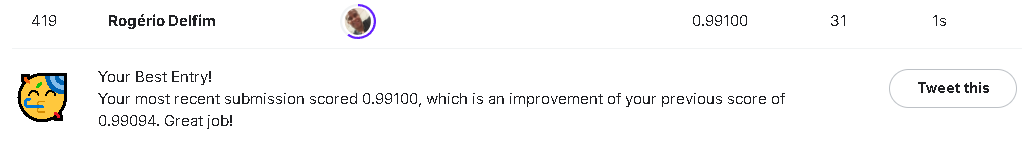

In [ ]:
#jb.dump(df_train_xgb, 'Data/pkl/df_nb_03_train_xgb.pkl.z')
#jb.dump(df_test_xgb,  'Data/pkl/df_nb_03_test_xgb.pkl.z')